In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers import Dense, Dropout, Flatten, Activation, Input, LSTM, GRU, Multiply, Add, SimpleRNN, Embedding
from sklearn.metrics import r2_score

from keras.models import Sequential, Model
from sklearn.model_selection import train_test_split

2022-04-17 10:38:43.938507: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-17 10:38:43.938550: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


the code is written using n, so just change the n here to see different results

In [2]:
n = 5
F = 8

In [3]:
# This is the right-hand side of the Lorenz-1996 system
def Lorenz96(x, t):

  dxdt = np.zeros(n)
  x = np.concatenate((x[-2:], x, x[:1]))

  for i in range(2, n+2):
    dxdt[i-2] = (x[i+1]-x[i-2])*x[i-1] - x[i] + F

  return dxdt

In [4]:
# The initial condition is (8.01,8,...,8)
x0 = F*np.ones(n)
x0[0] += 0.01

# This is where we want to evaluate the solution
t = np.arange(0., 100., 0.01)

# This produces the numerical solution of the Lorenz-1996 system
x = odeint(Lorenz96, x0, t)

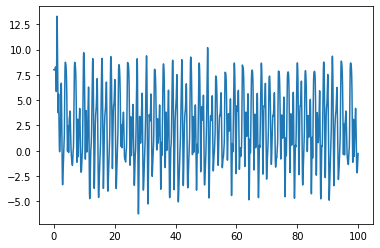

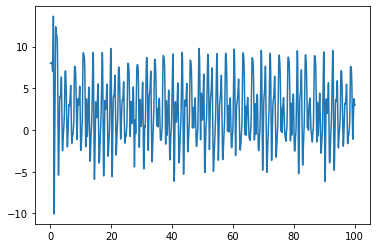

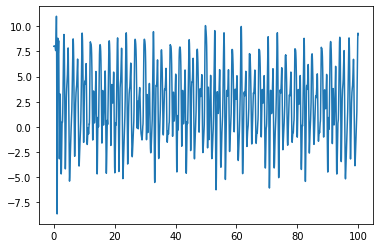

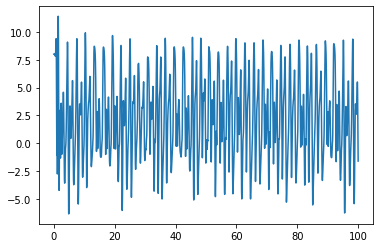

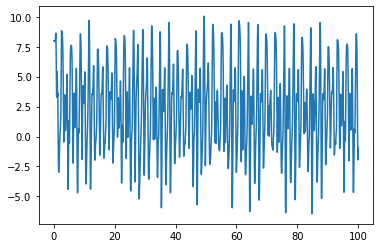

In [5]:
for i in range(n):
  plt.plot(t, x[:,i])
  plt.show()

In [6]:
scaler = StandardScaler()
normalized = scaler.fit_transform(x)

In [7]:
def split_dataset(x_len, y_len, data):
  X, Y = [],[]
  record_num = data.shape[0]//(x_len + y_len)
  for i in range(record_num):
    X.append(data[i:i+x_len])
    Y.append(data[i+x_len:i+x_len+y_len])
  return np.array(X), np.array(Y)

feature, target = split_dataset(128, 64, normalized)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, shuffle=True)

In [9]:
input = Input(shape=(X_train.shape[1:]))

x = Conv1D(128, kernel_size=33)(input)
x = Conv1D(64, kernel_size=33)(x)
x = Dense(units = n)(x)

model = Model(input, x)
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 5)]          0         
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           21248     
                                                                 
 conv1d_1 (Conv1D)           (None, 64, 64)            270400    
                                                                 
 dense (Dense)               (None, 64, 5)             325       
                                                                 
Total params: 291,973
Trainable params: 291,973
Non-trainable params: 0
_________________________________________________________________


2022-04-17 10:38:47.506379: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-17 10:38:47.506436: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gene): /proc/driver/nvidia/version does not exist
2022-04-17 10:38:47.507060: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
history = model.fit(X_train, y_train, batch_size=10, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
5/5 [==============================] - 1s 37ms/step - loss: 6.7665 - val_loss: 2.3148
Epoch 2/40
5/5 [==============================] - 0s 14ms/step - loss: 2.8197 - val_loss: 1.5587
Epoch 3/40
5/5 [==============================] - 0s 15ms/step - loss: 1.2082 - val_loss: 0.2521
Epoch 4/40
5/5 [==============================] - 0s 14ms/step - loss: 0.5670 - val_loss: 0.2617
Epoch 5/40
5/5 [==============================] - 0s 15ms/step - loss: 0.3567 - val_loss: 0.2315
Epoch 6/40
5/5 [==============================] - 0s 15ms/step - loss: 0.2193 - val_loss: 0.1804
Epoch 7/40
5/5 [==============================] - 0s 15ms/step - loss: 0.1525 - val_loss: 0.1114
Epoch 8/40
5/5 [==============================] - 0s 15ms/step - loss: 0.1448 - val_loss: 0.0479
Epoch 9/40
5/5 [==============================] - 0s 14ms/step - loss: 0.0773 - val_loss: 0.0661
Epoch 10/40
5/5 [==============================] - 0s 14ms/step - loss: 0.0718 - val_loss: 0.0426
Epoch 11/40
5/5 [============

loss through epoches

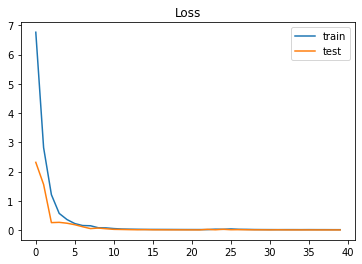

In [11]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [12]:
y_pred = model.predict(X_test)

The loss, mse, of the final model

In [13]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 14ms/step - loss: 0.0026


0.002567879157140851

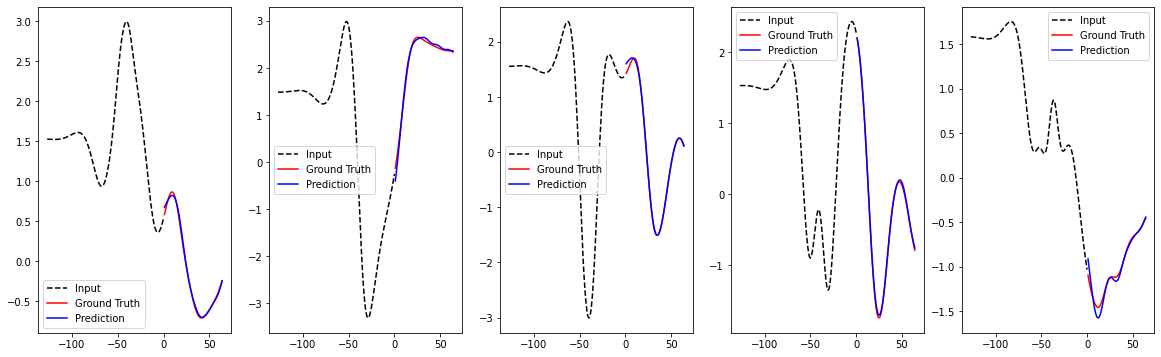

In [14]:
fig, ax = plt.subplots(1,n, figsize=(n*4,6))
for i in range(n):
  ax[i].plot(np.arange(-127, 1), X_test[0].T[i], 'k--', label='Input')
  ax[i].plot(np.arange(1,65), y_test[0].T[i], 'r', label='Ground Truth')
  ax[i].plot(np.arange(1,65), y_pred[0].T[i], 'b', label='Prediction')
  ax[i].legend()

# new x(0)

In [15]:
x_0 = (8.65, -2.42, 2.48, 1.04, 3.41)
x_new = odeint(Lorenz96, x_0, t)

In [16]:
normalized_new = scaler.fit_transform(x_new)
feature, target = split_dataset(128, 64, normalized)
_, X_test_new, _, y_test_new = train_test_split(feature, target, test_size=0.2, shuffle=True)

In [17]:
y_pred_new = model.predict(X_test_new)

The loss, mse, of the final model

In [18]:
model.evaluate(X_test_new, y_test_new)

1/1 [==============================] - 0s 12ms/step - loss: 0.0089


0.008928178809583187

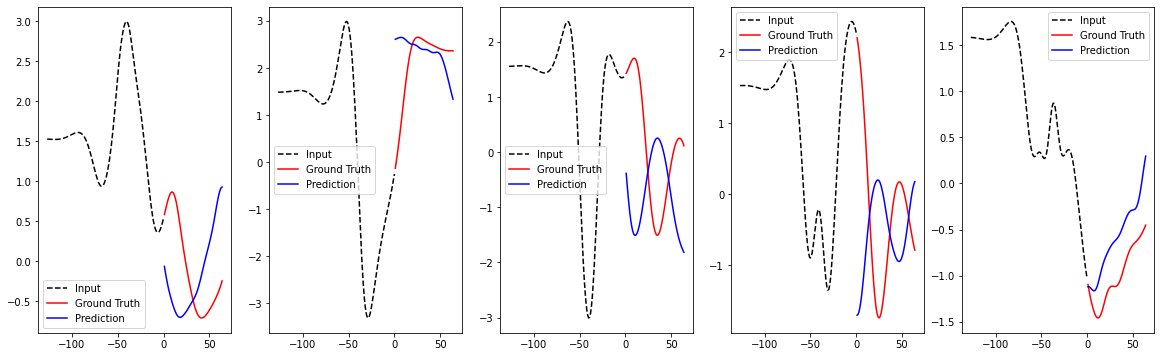

In [19]:
fig, ax = plt.subplots(1,n, figsize=(n*4,6))
for i in range(n):
  ax[i].plot(np.arange(-127, 1), X_test[0].T[i], 'k--', label='Input')
  ax[i].plot(np.arange(1,65), y_test[0].T[i], 'r', label='Ground Truth')
  ax[i].plot(np.arange(1,65), y_pred_new[0].T[i], 'b', label='Prediction')
  ax[i].legend()

so our model is generalizable